In [1]:
# 2018-06-12
# A. Pendleton
# Plotting heterozygosity estimates generated by Jeff

In [2]:
#this uses iPython magic to make plots appear inline
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import sys
import numpy as np
import matplotlib.patches as patches
import gzip
import fileinput
import glob
from scipy import stats
import re
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict


def count_lines(f):
    lineCount = 0
    with open(f, 'r') as f:
        for line in f:
            lineCount += 1
        return lineCount
def runCMD(cmd):
    val = subprocess.Popen(cmd, shell=True).wait()
    if val == 0:
        pass
    else:
        print ('command failed')
        print (cmd)
        sys.exit(1)
# TO REMOVE TOP AND RIGHT AXIS OF PLOTS
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

In [17]:
#All relevant files have been copied from Jeff's directory into the directory below:
#For reference, Jeff's directory with the original data and scripts can be found here:
#/home/jmkidd/links/kidd-lab/jmkidd-projects/zoey/heterzyogisty-analysis/

hetDir = '/home/ampend/links/kidd-lab/ampend-projects/Zoey_Genome_Project/Heterozygosity/'



### Read in sample information

In [108]:
infoFile = hetDir + 'input/' + 'CanineGenomeDatabase_2.txt'

data = {}
sampleDict = {}
canineTypes = []

for line in open(infoFile,'r'):
    if 'ProjectID' in line: #skips header
        print(line)
        continue
    
    line=line.rstrip().split('\t')
    sample = line[6]
    
    #If first time seeing sample name
    if sample not in sampleDict.keys():
        sampleDict[sample] = [line[3],line[4],line[5],line[6]]
    
    #Keep track of what type of canine this is, either breed/species/population
    if line[4] in canineTypes or line[3] in canineTypes:
        continue
    if 'Breed' in line[4]:
        canineTypes.append(line[3])
        continue
    if 'Ancient' in line[4]:
        canineTypes.append('Ancient Dog')
        continue
    if 'VillageDog' in line[4]:
        if 'China' in line[3]:
            canineTypes.append('China')
            continue
        if 'Nigeria' in line[3]:
            canineTypes.append('Nigeria')
            continue
        canineTypes.append(line[3])
        continue
    if 'olf' in line[4]:
        print(line[3])
        canineTypes.append(line[3])
    canineTypes.append(line[4])

    
print('%i samples added to sampleDict' % len(sampleDict.keys()))
print(canineTypes)

Red Wolf
Chinese wolf
364 samples added to sampleDict
['Ancient Dog', 'Andean Fox', 'Afghan Hound', 'Airedale Terrier', 'Alaskan Malamute', 'Australian Cattle Dog', 'Australian Shepherd', 'Australian Terrier', 'Basenji', 'Beagle', 'Belgian Sheepdog', 'Belgian Turvuren', 'Belgium Malinois', 'Berger Picard', 'Bernese Mountain Dog', 'Black & Tan Coonhound', 'Black Russian Terrier', 'Bloodhound', 'Border Collie', 'Border Terrier', 'Boxer', 'Brittany Spaniel', 'Bulldog', 'Cane Corso', 'Caucasian Ovcharka', 'Cavalier King Charles Spaniel', 'Chihuahua', 'Chinese Crested Terrier', 'Chinook', 'Chow Chow', 'Clumber Spaniel', 'Cocker Spaniel', 'Dingo', 'Doberman', 'Dogue De Bordeaux', 'East Siberian Laika', 'English Cocker Spaniel', 'English Mastiff', 'English Pointer', 'English Setter', 'English Springer Spaniel', 'Finnish Lapphund', 'Flat-coated Retreiver', 'Galgo', 'German Shepherd', 'Golden Retriever', 'Gordon Setter', 'Great Dane', 'Great Pyrenees', 'Greenland Dog', 'Grey Norwegian Elkhound'

# HET DATA
### Read in depth at sites 

In [109]:
depthFile = hetDir + 'input/' + 'hetstats.6.txt.depth'
sampleCount = 0 

for line in open(depthFile,'r'):
    if '#name' in line: #skip header
        continue
    line=line.rstrip().split('\t')
    sample = line[0]
    if sample not in sampleDict.keys():
        print('ERROR: sample not found: ', sample)
        break
    data[sample] = {}
    data[sample]['Sample_Description'] = sampleDict[sample][0]
    data[sample]['Sample_CanineType'] = sampleDict[sample][1]
    data[sample]['Sample_Sex'] = sampleDict[sample][2]
    data[sample]['Sample_ID'] = sampleDict[sample][3]
    data[sample]['Het_Depth'] = float(line[2])
    sampleCount +=1 
print('Added the depth at het sites for %i samples' % sampleCount)


Added the depth at het sites for 346 samples


### Het values at sites with at least 6x depth

In [110]:
inFile = hetDir + 'input/hetstats.6.txt'

for line in open(inFile,'r'):
    #Column info:
    #name	homRef	het	homAlt	fractionHet
    if '#' in line: 
        continue
    line = line.rstrip().split()
    sample = line[0]
    data[sample]['6x_HomRefCount'] = int(line[1])
    data[sample]['6x_HetCount'] = int(line[2])
    data[sample]['6x_HomAltCount'] = int(line[3])
    data[sample]['6x_FractionHet'] = float(line[4])
print('Done adding 6x het data')    

Done adding 6x het data


### Now plotting for samples with at least 6x depth

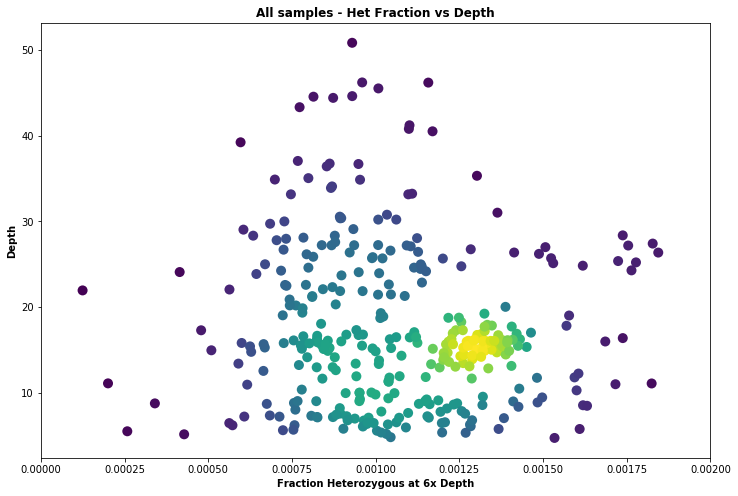

In [180]:
from scipy.stats import gaussian_kde

tooLowDepthSamples = []
x,y = [], []
for sample in data.keys():
    depth = data[sample]['Het_Depth']
    """if depth < 6:
        tooLowDepthSamples.append(sample)
        continue"""
    #Scatterplot
    x.append(data[sample]['6x_FractionHet'])
    y.append(data[sample]['Het_Depth'])

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)    

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x, y, c=z, s=100, edgecolor='')
plt.xlim(0,0.002)
plt.title('All samples - Het Fraction vs Depth', fontweight = 'bold')
plt.xlabel('Fraction Heterozygous at 6x Depth',fontweight='bold')
plt.ylabel('Depth',fontweight='bold')
plt.show()


### Determine which samples to keep/discard
#### Only want so many from each population/breed

In [121]:
sampleInfoFile = open(hetDir + 'input/' + 'Merged_SampleInfo_DepthAt6xHetSites.txt','w')
dataOrder = ['Sample_Description','Sample_CanineType','Het_Depth','6x_HomRefCount',
            '6x_HetCount','6x_HomAltCount','6x_FractionHet']

headerLine = []
headerLine.append('SampleID')
for dataColumn in dataOrder:
    headerLine.append(dataColumn)
sampleInfoFile.write('\t'.join(headerLine) + '\n')


for sample in data.keys():
    line = []
    line.append(sample)
    for dataColumn in dataOrder:
        line.append(str(data[sample][dataColumn]))
    sampleInfoFile.write('\t'.join(line) + '\n')
    
sampleInfoFile.close()

### Did the above by hand with the following criteria
1. Only two samples per population/breed
2. Samples with the highest het depth at in the 6x depth file were kept
3. If cross/mix was indicated in breed name, they were excluded
4. If no specific location was provided in geographic description on SRA, we kept it


In [155]:
#Determining the order I want to plot the dogs in for the bar plot 
plotOrder = []

samplesToKeep = hetDir + 'input/samples_to_plot_ordered.txt'
for line in open(samplesToKeep,'r'):
    line = line.rstrip().split('\t')
    if 'Sample' in line[0]: #skip header
        continue
    sample = line[0]
    #0 = sample, 1 = sample description, 2 = canine type, 3 = for plot description, 
    #4 = Het depth, #5 6x hom ref count, #6 6x het count, #7 hom alt count, #8 6x fraction het
    plotOrder.append([line[0],line[1],line[2],line[-1],float(line[4]),int(line[5]),int(line[6]),int(line[7]),float(line[8])])
print('%i samples read into Plot Order' % len(plotOrder))


182 samples read into Plot Order


### Plotting

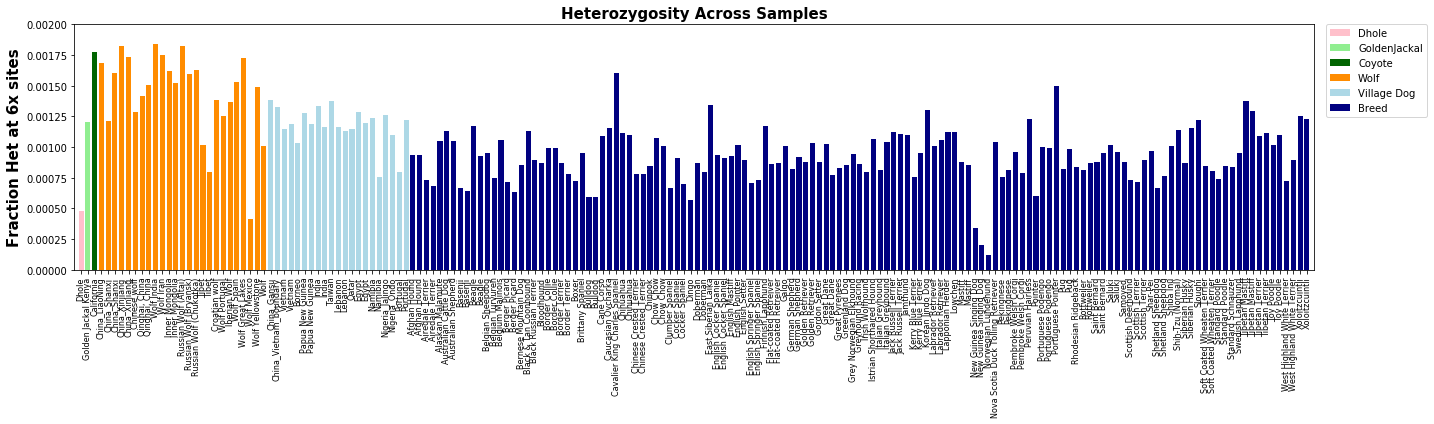

In [203]:
labelFont  = {'fontname':'Arial'}

width = .75

names = []
ticks = []
labels = {}
labels['Fox']  =1 
plt.figure(figsize=(20,6))
for i in range(len(plotOrder)):
    if plotOrder[i][2] == 'Fox':
        color = 'lightgreen'
    elif plotOrder[i][2] == 'GoldenJackal':
        color = 'lightgreen'
    elif plotOrder[i][2] == 'Coyote':
        color = 'darkgreen'
    elif plotOrder[i][2] == 'Wolf':
        color = 'darkorange'
    elif plotOrder[i][2] == 'AncientDog':
        color = 'red'
    elif plotOrder[i][2] == 'Village Dog':
        color = 'lightblue'
    elif plotOrder[i][2] == 'Breed':
        color = 'navy'
    elif plotOrder[i][2] == 'New Guinea Singing Dog':
        color = 'steelblue'
    else:
        color = 'pink'
    if plotOrder[i][2] in labels:        
        _ = plt.bar(i,plotOrder[i][8],width,align='center',color=color)
    else:
        l = plotOrder[i][2]
        labels[l] = 1
        if l == 'Jackal':
            l = 'Fox and Jackal'
            
        if l == 'AncientDog':
            l = 'Ancient Dog'

        if l == 'VillageDog':
            l = 'Village Dog'
            
        _ = plt.bar(i,plotOrder[i][8],width,align='center',color=color,label=l)
    names.append(plotOrder[i][1])
    ticks.append(i)


_ =plt.xticks(ticks,names,rotation=90,fontsize=8)
_ = plt.xlim([-1,ticks[-1]+1])
_ = plt.ylim([0,0.002])

#plt.legend(loc=4)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

plt.axhline(y=2,color='dimgrey',linestyle='--',linewidth=2)
plt.ylabel('Fraction Het at 6x sites', fontweight='bold',fontsize=15)
plt.title('Heterozygosity Across Samples',fontsize=15,fontweight='bold')

plt.tight_layout()
plotFile = hetDir + 'plots/Heterozygosity_6x_FilteredSampleSet_Barchart.png'
plt.savefig(plotFile, format='png', dpi=200)

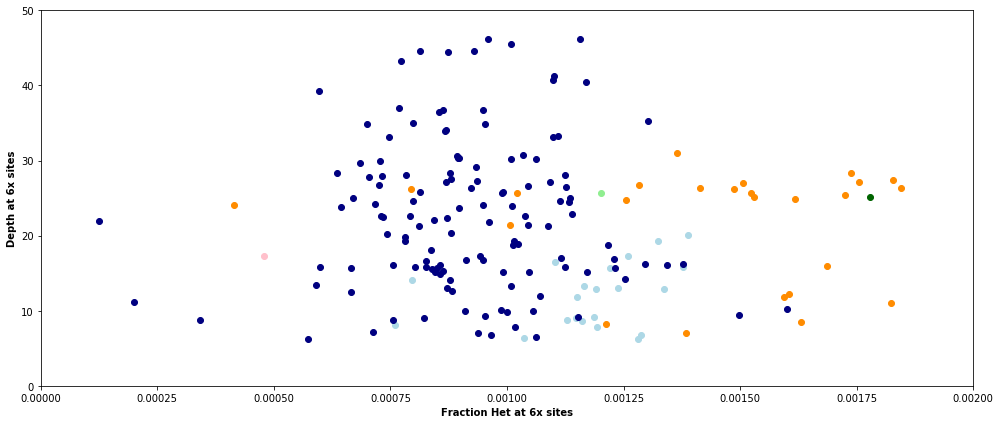

In [193]:
labelFont  = {'fontname':'Arial'}

width = .75

names = []
ticks = []
labels = {}
labels['Fox']  =1 
plt.figure(figsize=(14,6))
for i in range(len(plotOrder)):
    if plotOrder[i][2] == 'Fox':
        color = 'lightgreen'
    elif plotOrder[i][2] == 'GoldenJackal':
        color = 'lightgreen'
    elif plotOrder[i][2] == 'Coyote':
        color = 'darkgreen'
    elif plotOrder[i][2] == 'Wolf':
        color = 'darkorange'
    elif plotOrder[i][2] == 'AncientDog':
        color = 'red'
    elif plotOrder[i][2] == 'Village Dog':
        color = 'lightblue'
    elif plotOrder[i][2] == 'Breed':
        color = 'navy'
    elif plotOrder[i][2] == 'New Guinea Singing Dog':
        color = 'steelblue'
    else:
        color = 'pink'
    if plotOrder[i][2] in labels:        
        y,x = plotOrder[i][4],plotOrder[i][8]
        _ = plt.scatter(x,y,color=color,label=l)
    else:
        l = plotOrder[i][2]
        labels[l] = 1
        if l == 'Jackal':
            l = 'Fox and Jackal'
            
        if l == 'AncientDog':
            l = 'Ancient Dog'

        if l == 'VillageDog':
            l = 'Village Dog'

            
        y,x = plotOrder[i][4],plotOrder[i][8]
        _ = plt.scatter(x,y,color=color,label=l)
    names.append(plotOrder[i][1])
    ticks.append(i)


_ = plt.ylim([0,50])
_ = plt.xlim([0,0.002])

plt.xlabel('Fraction Het at 6x sites',fontweight='bold')
plt.ylabel('Depth at 6x sites',fontweight='bold')
#plt.title('ddPCR Estimated AMY2B Duplication Copy Number')

plt.tight_layout()
plotFile = hetDir + 'plots/Heterozygosity_6x_FilteredSampleSet_Scatter.png'
plt.savefig(plotFile, format='png', dpi=200)